# Mel frequency scale
> Experiments with convertion to/from Mel frequency scale
## Good readings
- http://kom.aau.dk/group/04gr742/pdf/MFCC_worksheet.pdf
- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
- https://librosa.github.io/librosa/generated/librosa.filters.mel.html


In [2]:
import librosa as lr
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [3]:
# apply a mel spectrogram as per docs
y, sr = librosa.load(librosa.util.example_audio_file())
S1 = librosa.feature.melspectrogram(y=y, sr=sr)


# using a precalculated power spectrum
D = np.abs(librosa.stft(y, n_fft=2048))**2
n_fft = 2 * (D.shape[0] - 1)
S2 = librosa.feature.melspectrogram(S=D)

print('Shape: {}'.format(S1.shape))
# print(S1)
print('Shape: {}'.format(S2.shape))
# print(S2)

# are they the same?
print(mean_squared_error(S1, S2))

Shape: (128, 2647)
Shape: (128, 2647)
0.0


Shape: (128, 1025)


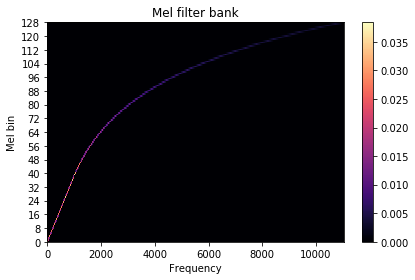

In [4]:
# yes they are! let's make a mel filter manually

# create filter as per docs
# https://librosa.github.io/librosa/generated/librosa.filters.mel.html?highlight=mel#librosa.filters.mel
from matplotlib.ticker import Formatter, ScalarFormatter


melfb = librosa.filters.mel(sr, n_fft)
print('Shape: {}'.format(melfb.shape))
plt.figure()
ax = librosa.display.specshow(melfb, x_axis='linear')
ax.yaxis.set_ticks(np.arange(melfb.shape[0]+1)[0::8])
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Frequency')
plt.ylabel('Mel bin')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()


In [5]:
# using our mel filter
S3 = np.dot(melfb, D)

# is this also the same?
print('Shape: {}'.format(S3.shape))
print(mean_squared_error(S1, S3))

Shape: (128, 2647)
0.0


Text(0.5, 1.0, 'Mel spectrogram (3)')

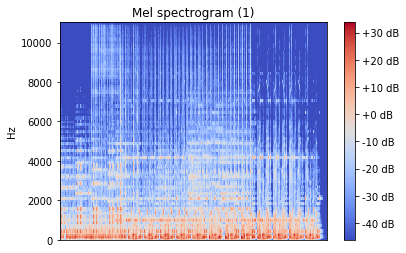

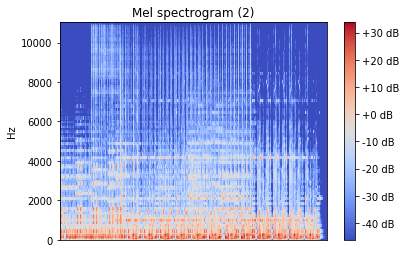

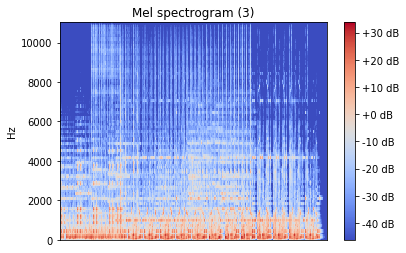

In [6]:
# let's check what they look like
plt.figure()
librosa.display.specshow(librosa.power_to_db(S1), y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram (1)')

plt.figure()
librosa.display.specshow(librosa.power_to_db(S2), y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram (2)')

plt.figure()
librosa.display.specshow(librosa.power_to_db(S3), y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram (3)')

Shape: (1025, 128)


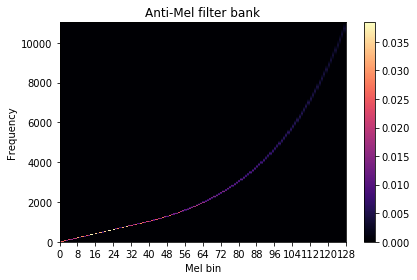

In [7]:
# yes it is! I just learned how to apply a mel filter.
# let's try to apply it in reverse!

# transpose the mel filter
linfb = melfb.T
print('Shape: {}'.format(linfb.shape))
plt.figure()
ax = librosa.display.specshow(linfb, x_axis=None, y_axis='linear')
ax.xaxis.set_ticks(np.arange(linfb.shape[1]+1)[0::8])
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.ylabel('Frequency')
plt.xlabel('Mel bin')
plt.title('Anti-Mel filter bank')
plt.colorbar()
plt.tight_layout()


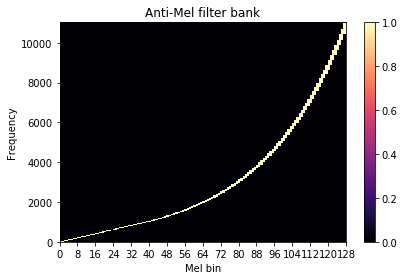

In [8]:
# Riccardo from the future writing here,
# I already tested this and it doesn't
# work (mse = ~53037). Let's set it all to 1?

thrs = 0
linfb2 = np.zeros(linfb.shape)
linfb2[linfb > thrs] = 1 
# normalization: 1 / np.sum(linfb > thrs) * np.sum(linfb)

# let's replot this
plt.figure()
ax = librosa.display.specshow(linfb2, x_axis=None, y_axis='linear')
ax.xaxis.set_ticks(np.arange(linfb2.shape[1]+1)[0::8])
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.ylabel('Frequency')
plt.xlabel('Mel bin')
plt.title('Anti-Mel filter bank')
plt.colorbar()
plt.tight_layout()

In [9]:
# also, is the amount of energy/power/whatevs maintained?
print(np.sum(melfb))
print(np.sum(linfb))
print(np.sum(linfb2))

11.886681289558458
11.886681289558458
2018.0


In [10]:
# getting the reconstructed spectr
D2 = np.dot(linfb2, S3)

# how much does it differ from the original?
print(mean_squared_error(D, D2))

# print('Shape: {}'.format(D.shape))
# print(np.min(D))
# print('Shape: {}'.format(D2.shape))
# print(np.min(D2))


44722.75551207689


Text(0.5, 1.0, 'Reconverted spectrogram')

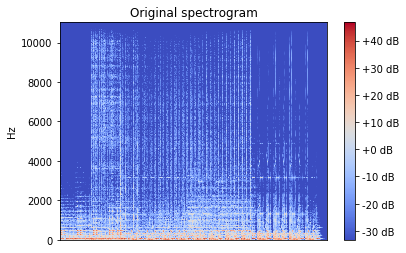

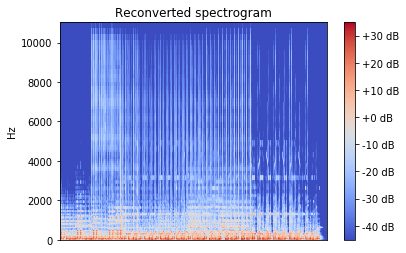

In [11]:
plt.figure()
librosa.display.specshow(librosa.power_to_db(D), y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Original spectrogram')

plt.figure()
librosa.display.specshow(librosa.power_to_db(D2), y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconverted spectrogram')

In [12]:
# convert back to audio and play!
# (use phases of original signal)
librosa.istft(D)

array([5.1473226e-06, 5.3854023e-06, 6.6577263e-06, ..., 2.3248432e-10,
       2.2220049e-10, 2.1207876e-10], dtype=float32)

In [13]:
D.shape

(1025, 2647)